# Model performance

After training all SVMs, we assess model performance using precision and recall of both outcome classes.

### Importing packages

In [1]:
import numpy as np
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import shap

import pickle
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

### Functions to read files created by 2_modeltraining.py

In [8]:
def pretty_results(filenames, filepath='../results/models/'):
    reslist = []
    for index1, filename in enumerate(filenames):
        res = pd.read_pickle(filepath+filename+'.pkl')
        for index2, cr in enumerate(res):
            trainval = ['train', 'val'][index2 % 2]
            sex = ['M', 'M', 'F', 'F'][index2 % 4]
            reslist.append([index1+1, trainval, sex, cr['0']['precision'], cr['0']['recall'], cr['0']['support'],
                            cr['1']['precision'], cr['1']['recall'], cr['1']['support']])
    res = pd.DataFrame(reslist).set_axis(['nback', 'trainval', 'sex', 'ok_precision', 'ok_recall', 'ok_support',
                                          'low_precision', 'low_recall', 'low_support'], axis=1)
    return(res)
    
def get_scores(res_df):
    res_df['old_defrate'] = res_df['low_support'] / (res_df['low_support'] + res_df['ok_support'])
    res_df['new_defrate'] = 1 - res_df['ok_precision']
    res_df['missed_dons'] = 1 - res_df['ok_recall']
    res_df['prevented_defs'] = res_df['low_recall']
    res_df['missed_per_prev'] = (res_df['ok_support'] - res_df['ok_recall'] * res_df['ok_support']) / (res_df['low_support'] - (1 - res_df['ok_precision']) * res_df['ok_support'])
    
    res_df['old_def_n'] = res_df['low_support']
    res_df['new_def_n'] = round((1 - res_df['ok_precision']) * res_df['ok_support'])
    res_df['old_don_n'] = res_df['ok_support']
    res_df['new_don_n'] = res_df['ok_recall'] * res_df['ok_support']
    
    return(res_df)

def plot_precision_recall_all(res_df):
    pl_df = res_df.groupby(['sex', 'trainval'])

    fig, ax = plt.subplots(5, 2, figsize=(10, 12), sharey='row')

    for name, group in pl_df:
        y = 0 if name[0] == 'F' else 1
        off = -0.2 if name[1] == 'train' else 0.2
        ax[0, y].bar(group.nback + off, group.ok_precision, label=name[1], width=0.4, edgecolor='white')
        # ax[0, y].set_ylim(0.95, 1)
        ax[1, y].bar(group.nback + off, group.ok_recall, label=name[1], width=0.4, edgecolor='white')
        # ax[1, y].set_ylim(0.6, 0.85)
        
        ax[2, y].bar(group.nback + off, group.low_precision, label=name[1], width=0.4, edgecolor='white')
        # ax[2, y].set_ylim(0.95, 1)
        ax[3, y].bar(group.nback + off, group.low_recall, label=name[1], width=0.4, edgecolor='white')
        # ax[3, y].set_ylim(0.65, 0.85)
        
        ax[4, y].bar(group.nback + off, group.missed_per_prev, label=name[1], width=0.4, edgecolor='white')

    ax[0, 1].legend(bbox_to_anchor=(1, 1), loc='upper left', title='Group')

    cols = ['Women', 'Men']
    rows = ['Precision - Good Hb', 'Recall - Good Hb', 'Precision - Low Hb', 'Recall - Low Hb', 'Missed donations \nper prevented deferral']
    xlabs = ['Model'] * 5 

    for aks, row in zip(ax[:, 0], rows):
        aks.set_ylabel(row, size='large')

    for aks, col, xlab in zip(ax[0,:], cols, xlabs):
        aks.set_title(col, size='large')
        aks.set_xlabel(xlab)

    for aks, xlab in zip(ax[1,:], xlabs):
        aks.set_xlabel(xlab)

    fig.tight_layout()
    plt.set_cmap('tab20')
    plt.show()
    
def plot_precision_recall(res_df, measure, ylim, ylab, save=False):
    pl_df = res_df.groupby(['sex', 'trainval'])

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    for name, group in pl_df:
        y = 0 if name[0] == 'F' else 1
        off = -0.2 if name[1] == 'train' else 0.2
        hatch = '/' if name[1] == 'val' else ''
        ax[y].bar(group.nback + off, group[measure], label=name[1], width=0.4, edgecolor='black', hatch=hatch)
        ax[y].set_ylim(ylim)
        ax[y].set_xticks(group.nback)
        ax[y].set_xticklabels(['SVM-1','SVM-2','SVM-3','SVM-4','SVM-5'], size='large')
        ax[y].set_ylabel(ylab, size='large')

    ax[0].legend(labels=['train', 'test'], bbox_to_anchor=(0, 0), loc='lower left', title='Dataset')
    ax[1].legend(labels=['train', 'test'], bbox_to_anchor=(0, 0), loc='lower left', title='Dataset')
    
    ax[0].set_title('Women')
    ax[1].set_title('Men')

    fig.tight_layout()
    plt.set_cmap('tab20')
    
    if save:
        path = '../results/plots_performance/'
        plt.savefig(path+save+'.png')
    
    plt.show()
    
def plot_precision_recall_comp(res_df, measure, ylim, ylab, save=False):
    pl_df = res_df.loc[res_df['trainval'] == 'val'].groupby(['sex', 'vars'])

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    for name, group in pl_df:
        y = 0 if name[0] == 'F' else 1
        off = -0.2 if name[1] == 'all' else 0.2
        hatch = '/' if name[1] == 'all' else ''
        colr = 'deepskyblue' if name[1] == 'all' else 'rebeccapurple'
        ax[y].bar(group.nback + off, group[measure], label=name[1], width=0.4, edgecolor='black', 
                  hatch=hatch, color=colr)
        ax[y].set_ylim(ylim)
        ax[y].set_xticks(group.nback)
        ax[y].set_xticklabels(['SVM-1','SVM-2','SVM-3','SVM-4','SVM-5'], size='large')
        ax[y].set_ylabel(ylab, size='large')

    ax[0].legend(labels=['all', 'only Hb'], bbox_to_anchor=(0, 0), loc='lower left', title='Predictor\nvariables')
    ax[1].legend(labels=['all', 'only Hb'], bbox_to_anchor=(0, 0), loc='lower left', title='Predictor\nvariables')
    
    ax[0].set_title('Women')
    ax[1].set_title('Men')

    fig.tight_layout()
    
    if save:
        path = '../results/plots_performance/'
        plt.savefig(path+save+'.png')
    
    plt.show()

# Results all SVMs, all variables

In [3]:
res_df = pretty_results(['res_1', 'res_2', 'res_3', 'res_4', 'res_5'], filepath='../results/models/')
res_df = get_scores(res_df)

In [4]:
res_df

,nback,trainval,sex,ok_precision,ok_recall,ok_support,low_precision,low_recall,low_support,old_defrate,new_defrate,missed_dons,prevented_defs,missed_per_prev,old_def_n,new_def_n,old_don_n,new_don_n
0,1,train,M,0.995710,0.710088,66027,0.052189,0.839172,1256,0.018667,0.004290,0.289912,0.839172,19.678258,1256,283.0,66027,46885.0
1,1,val,M,0.997475,0.760416,21817,0.034005,0.814159,226,0.010253,0.002525,0.239584,0.814159,30.583963,226,55.0,21817,16590.0
2,1,train,F,0.986862,0.675056,60198,0.098655,0.798285,2682,0.042653,0.013138,0.324944,0.798285,10.343641,2682,791.0,60198,40637.0
3,1,val,F,0.992535,0.732697,21051,0.070685,0.786765,544,0.025191,0.007465,0.267303,0.786765,14.545218,544,157.0,21051,15424.0
4,2,train,M,0.996083,0.721028,55726,0.053919,0.848659,1044,0.018390,0.003917,0.278972,0.848659,18.827052,1044,218.0,55726,40180.0
5,2,val,M,0.997511,0.786045,21411,0.037605,0.809955,221,0.010216,0.002489,0.213955,0.809955,27.316486,221,53.0,21411,16830.0
6,2,train,F,0.988780,0.701362,46240,0.104533,0.814141,1980,0.041062,0.011220,0.298638,0.814141,9.450491,1980,519.0,46240,32431.0
7,2,val,F,0.992108,0.770882,20221,0.078743,0.761538,520,0.025071,0.007892,0.229118,0.761538,12.854636,520,160.0,20221,15588.0
8,3,train,M,0.996540,0.705689,46529,0.050347,0.864286,840,0.017733,0.003460,0.294311,0.864286,20.167459,840,161.0,46529,32835.0
9,3,val,M,0.997844,0.782642,20694,0.038272,0.836449,214,0.010235,0.002156,0.217358,0.836449,26.556280,214,45.0,20694,16196.0


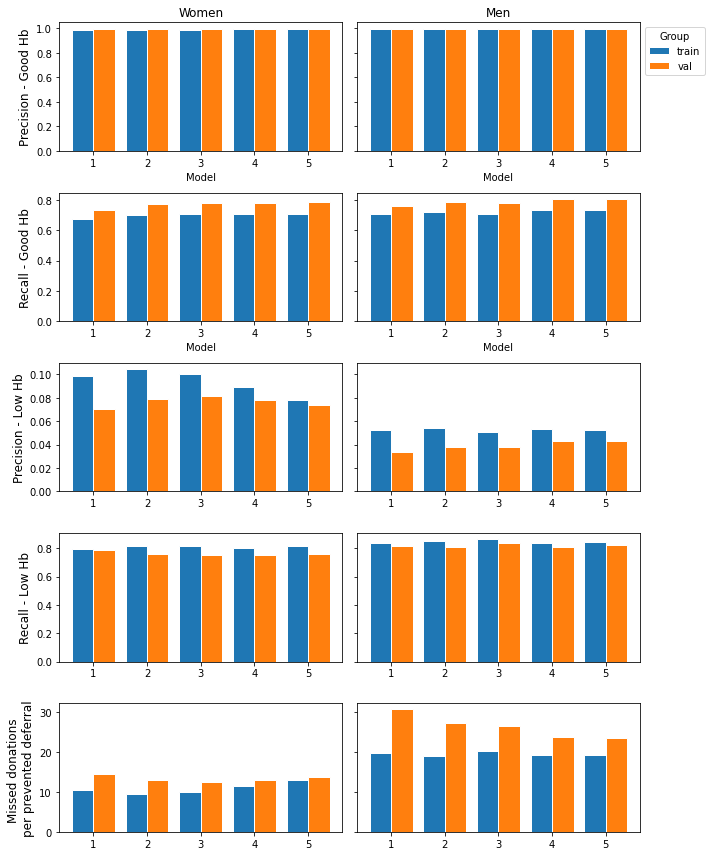

In [5]:
plot_precision_recall_all(res_df)

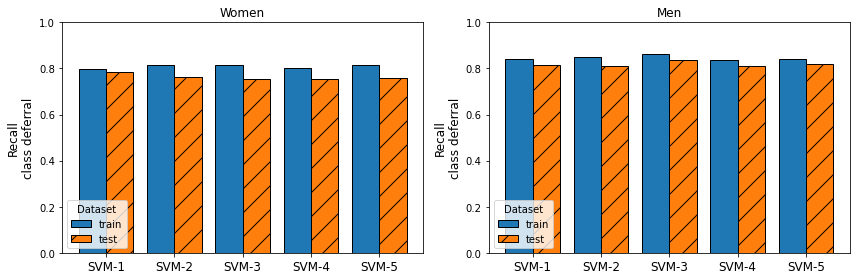

In [21]:
plot_precision_recall(res_df, 'low_recall', (0, 1), 'Recall\nclass deferral', save='low_recall')

# Results all SVMs, only Hb variables

In [22]:
res_df_onlyhb = pretty_results(['res_1', 'res_2', 'res_3', 'res_4', 'res_5'], filepath='../results/models_onlyhb/')
res_df_onlyhb = get_scores(res_df_onlyhb)
res_df_onlyhb

,nback,trainval,sex,ok_precision,ok_recall,ok_support,low_precision,low_recall,low_support,old_defrate,new_defrate,missed_dons,prevented_defs,missed_per_prev,old_def_n,new_def_n,old_don_n,new_don_n
0,1,train,M,0.995361,0.695428,66027,0.049262,0.829618,1256,0.018667,0.004639,0.304572,0.829618,21.175037,1256,306.0,66027,45917.0
1,1,val,M,0.996946,0.748178,21817,0.031041,0.778761,226,0.010253,0.003054,0.251822,0.778761,34.472142,226,67.0,21817,16323.0
2,1,train,F,0.987926,0.632031,60198,0.090980,0.826622,2682,0.042653,0.012074,0.367969,0.826622,11.329509,2682,727.0,60198,38047.0
3,1,val,F,0.992870,0.694599,21051,0.063920,0.806985,544,0.025191,0.007130,0.305401,0.806985,16.320930,544,150.0,21051,14622.0
4,2,train,M,0.996531,0.690755,55726,0.050157,0.871648,1044,0.018390,0.003469,0.309245,0.871648,20.257857,1044,193.0,55726,38493.0
5,2,val,M,0.997665,0.758162,21411,0.034135,0.828054,221,0.010216,0.002335,0.241838,0.828054,30.281442,221,50.0,21411,16233.0
6,2,train,F,0.990354,0.650562,46240,0.094536,0.852020,1980,0.041062,0.009646,0.349438,0.852020,10.533488,1980,446.0,46240,30082.0
7,2,val,F,0.993268,0.722368,20221,0.069760,0.809615,520,0.025071,0.006732,0.277632,0.809615,14.624616,520,136.0,20221,14607.0
8,3,train,M,0.996700,0.694578,46529,0.049050,0.872619,840,0.017733,0.003300,0.305422,0.872619,20.701925,840,154.0,46529,32318.0
9,3,val,M,0.997809,0.770272,20694,0.036286,0.836449,214,0.010235,0.002191,0.229728,0.836449,28.186712,214,45.0,20694,15940.0


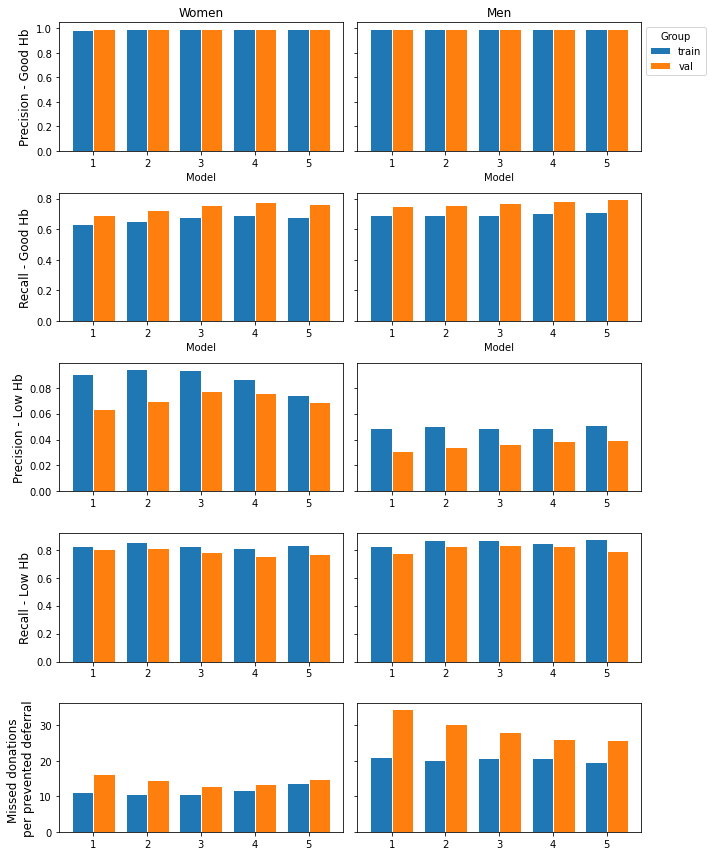

In [23]:
plot_precision_recall_all(res_df_onlyhb)

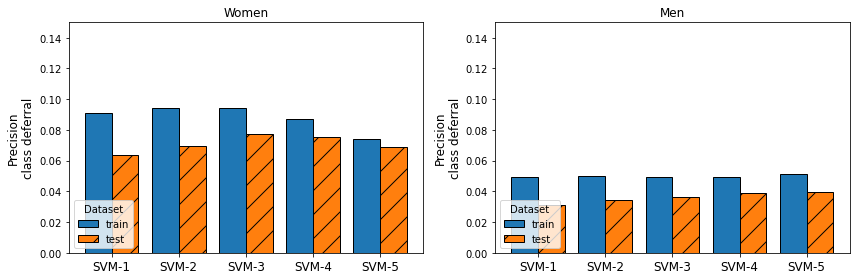

In [37]:
plot_precision_recall(res_df_onlyhb, 'low_precision', (0, 0.15), 'Precision\nclass deferral', save='onlyhb_low_precision')

# Comparing performance between all vars and only Hb vars
Showing only the performance on the test set

In [38]:
res_df['vars'] = 'all'
res_df_onlyhb['vars'] = 'onlyhb'

res_tot = pd.concat([res_df, res_df_onlyhb])
res_tot.head()

,nback,trainval,sex,ok_precision,ok_recall,ok_support,low_precision,low_recall,low_support,old_defrate,new_defrate,missed_dons,prevented_defs,missed_per_prev,old_def_n,new_def_n,old_don_n,new_don_n,vars
0,1,train,M,0.995710,0.710088,66027,0.052189,0.839172,1256,0.018667,0.004290,0.289912,0.839172,19.678258,1256,283.0,66027,46885.0,all
1,1,val,M,0.997475,0.760416,21817,0.034005,0.814159,226,0.010253,0.002525,0.239584,0.814159,30.583963,226,55.0,21817,16590.0,all
2,1,train,F,0.986862,0.675056,60198,0.098655,0.798285,2682,0.042653,0.013138,0.324944,0.798285,10.343641,2682,791.0,60198,40637.0,all
3,1,val,F,0.992535,0.732697,21051,0.070685,0.786765,544,0.025191,0.007465,0.267303,0.786765,14.545218,544,157.0,21051,15424.0,all
4,2,train,M,0.996083,0.721028,55726,0.053919,0.848659,1044,0.018390,0.003917,0.278972,0.848659,18.827052,1044,218.0,55726,40180.0,all


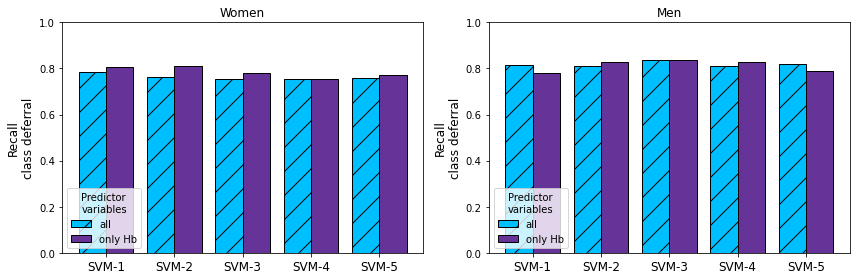

In [53]:
plot_precision_recall_comp(res_tot, 'low_recall', (0, 1), 'Recall\nclass deferral', save='compare_low_recall')

In [58]:
comp_res = res_tot.loc[res_tot['trainval'] == 'val', 
                       ['nback', 'sex', 
                        'ok_precision', 'ok_recall',
                        'low_precision', 'low_recall', 
                        'vars']].pivot(index=['nback', 'sex'], columns='vars')

comp_res['ok_precision', 'diff'] = comp_res['ok_precision', 'all'] - comp_res['ok_precision', 'onlyhb']
comp_res['ok_recall', 'diff'] = comp_res['ok_recall', 'all'] - comp_res['ok_recall', 'onlyhb']
comp_res['low_precision', 'diff'] = comp_res['low_precision', 'all'] - comp_res['low_precision', 'onlyhb']
comp_res['low_recall', 'diff'] = comp_res['low_precision', 'all'] - comp_res['low_precision', 'onlyhb']

comp_res

ok_precision           ok_recall           low_precision            \
vars               all    onlyhb       all    onlyhb           all    onlyhb   
nback sex                                                                      
1     F       0.992535  0.992870  0.732697  0.694599      0.070685  0.063920   
      M       0.997475  0.996946  0.760416  0.748178      0.034005  0.031041   
2     F       0.992108  0.993268  0.770882  0.722368      0.078743  0.069760   
      M       0.997511  0.997665  0.786045  0.758162      0.037605  0.034135   
3     F       0.991993  0.992672  0.781890  0.760764      0.081532  0.077351   
      M       0.997844  0.997809  0.782642  0.770272      0.038272  0.036286   
4     F       0.992391  0.992316  0.782464  0.774860      0.078046  0.075610   
      M       0.997557  0.997678  0.808159  0.784819      0.042785  0.038976   
5     F       0.993159  0.993330  0.785540  0.765521      0.073890  0.069012   
      M       0.997669  0.997239  0.807755  0.798479      0.043210  0.039825   

          low_recall           ok_precision ok_recall low_precision low_recall  
vars             all    onlyhb         diff      diff          diff       diff  
nback sex                                                                       
1     F     0.786765  0.806985    -0.000335  0.038098      0.006766   0.006766  
      M     0.814159  0.778761     0.000529  0.012238      0.002964   0.002964  
2     F     0.761538  0.809615    -0.001160  0.048514      0.008984   0.008984  
      M     0.809955  0.828054    -0.000154  0.027883      0.003470   0.003470  
3     F     0.754167  0.781250    -0.000679  0.021126      0.004180   0.004180  
      M     0.836449  0.836449     0.000035  0.012371      0.001986   0.001986  
4     F     0.754258  0.754258     0.000074  0.007604      0.002437   0.002437  
      M     0.812500  0.826923    -0.000121  0.023340      0.003809   0.003809  
5     F     0.759760  0.771772    -0.000171  0.020019      0.004878   0.004878  
      M     0.821429  0.790816     0.000430  0.009275      0.003385   0.003385

## Precision-recall curves
Classifying observations in the test set again, now saving probability of deferral as determined by SVM in order to plot PR-curves

In [59]:
# for models using all predictor variables

for nback in range(1,6):
    file_clf = '../results/models/clf_' + str(nback) + '.sav'
    clfs = pickle.load(open(file_clf, 'rb'))
    for index, sex in enumerate(['men', 'women']):
        print(datetime.datetime.now(), 'Starting', nback, sex)
        clf = clfs[index]
        test = pd.read_pickle('../../data/scaled/'+str(sex)+'_'+str(nback)+'_test.pkl') 
        y_true = test[test.columns[-1:]].copy()
        y_pred = clf.predict_proba(test[test.columns[:-1]])
        y_true[['prob_low', 'prob_ok']] = y_pred
        file_preds = '../results/probas/proba_' + sex + '_' + str(nback) + '.pkl'
        pickle.dump(y_true, open(file_preds, 'wb'))

2022-06-28 09:25:11.632698 Starting 1 men
2022-06-28 09:26:20.486108 Starting 1 women
2022-06-28 09:27:35.063365 Starting 2 men
2022-06-28 09:28:31.317180 Starting 2 women
2022-06-28 09:29:22.951764 Starting 3 men
2022-06-28 09:30:15.537625 Starting 3 women
2022-06-28 09:30:50.090844 Starting 4 men
2022-06-28 09:31:29.223376 Starting 4 women
2022-06-28 09:31:54.996241 Starting 5 men
2022-06-28 09:32:21.654653 Starting 5 women


In [71]:
# for models using only Hb variables

for nback in range(1,6):
    file_clf = '../results/models_onlyhb/clf_' + str(nback) + '.sav'
    clfs = pickle.load(open(file_clf, 'rb'))
    for index, sex in enumerate(['men', 'women']):
        print(datetime.datetime.now(), 'Starting', nback, sex)
        clf = clfs[index]
        test = pd.read_pickle('../../data/scaled_onlyhb/'+str(sex)+'_'+str(nback)+'_test.pkl') 
        y_true = test[test.columns[-1:]].copy()
        y_pred = clf.predict_proba(test[test.columns[:-1]])
        y_true[['prob_low', 'prob_ok']] = y_pred
        file_preds = '../results/probas_onlyhb/proba_' + sex + '_' + str(nback) + '.pkl'
        pickle.dump(y_true, open(file_preds, 'wb'))

2022-06-28 10:07:05.970161 Starting 1 men
2022-06-28 10:08:09.857671 Starting 1 women
2022-06-28 10:09:14.700425 Starting 2 men
2022-06-28 10:10:04.592944 Starting 2 women
2022-06-28 10:10:50.956038 Starting 3 men
2022-06-28 10:11:31.347751 Starting 3 women
2022-06-28 10:12:04.270275 Starting 4 men
2022-06-28 10:12:43.701293 Starting 4 women
2022-06-28 10:13:06.041109 Starting 5 men
2022-06-28 10:13:31.015501 Starting 5 women


In [69]:
# Calculating deferral rates for baseline in PR curve
proba_m = pd.read_pickle('../results/probas/proba_men_1.pkl')
proba_f = pd.read_pickle('../results/probas/proba_women_1.pkl')
def_m = np.mean(proba_m.Hb_deferral)
def_f = np.mean(proba_f.Hb_deferral)

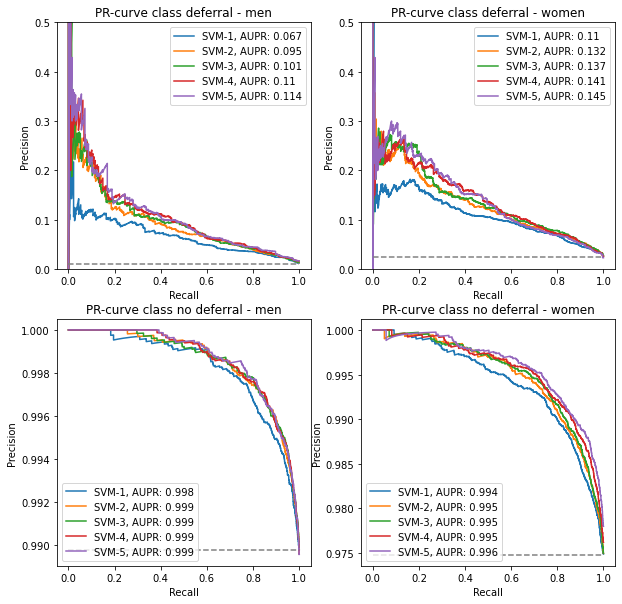

In [82]:
def load_probas(sexes = ['men', 'women'], path = '../results/probas/proba_', nbacks = range(1, 6)):
    dfs = []
    for sex in sexes:
        for nback in nbacks:
            df = pd.read_pickle(path + sex + '_' + str(nback) + '.pkl')
            df['sex'] = sex
            df['nback'] = nback
            dfs.append(df)
    fulldf = pd.concat(dfs)
    return(fulldf)

def plot_prs(probas, save=False):
    fig, ax = plt.subplots(2, 2, figsize=(10,10))
    
    for x, sex in enumerate(['men', 'women']):
        df = probas.loc[probas['sex'] == sex, ]
        
        for key, group in df.groupby('nback'):
            precision_0, recall_0, thresholds_0 = precision_recall_curve(group.Hb_deferral, group.prob_low, pos_label=0)
            precision_1, recall_1, thresholds_1 = precision_recall_curve(group.Hb_deferral, group.prob_ok, pos_label=1)
            
            aupr_0 = round(average_precision_score(group.Hb_deferral, group.prob_low, pos_label=0), 3)
            aupr_1 = round(average_precision_score(group.Hb_deferral, group.prob_ok, pos_label=1), 3)

            ax[1,x].plot(recall_0, precision_0, label='SVM-'+str(key)+', AUPR: '+str(aupr_0))
            ax[0,x].plot(recall_1, precision_1, label='SVM-'+str(key)+', AUPR: '+str(aupr_1))
        
        ax[0,x].set_title('PR-curve class deferral - ' + ['men', 'women'][x])
        ax[0,x].set_xlabel('Recall')
        ax[0,x].set_ylabel('Precision')
        ax[1,x].set_title('PR-curve class no deferral - ' + ['men', 'women'][x])
        ax[1,x].set_xlabel('Recall')
        ax[1,x].set_ylabel('Precision')
        ax[0,x].legend(loc='upper right')
        ax[1,x].legend(loc='lower left')
        ax[0,x].set_ylim(0,0.5)
    
    #horizontal lines for baseline
    ax[0,0].hlines(y=def_m, xmin=0, xmax=1, color='grey', ls='--')
    ax[1,0].hlines(y=1-def_m, xmin=0, xmax=1, color='grey', ls='--')
    ax[0,1].hlines(y=def_f, xmin=0, xmax=1, color='grey', ls='--')
    ax[1,1].hlines(y=1-def_f, xmin=0, xmax=1, color='grey', ls='--')
    
    if save:
        path = '../results/plots_performance/'
        plt.savefig(path+save+'.png')
    
    plt.show()

probas = load_probas()
#probas.head()
plot_prs(probas, save='PR_curve')

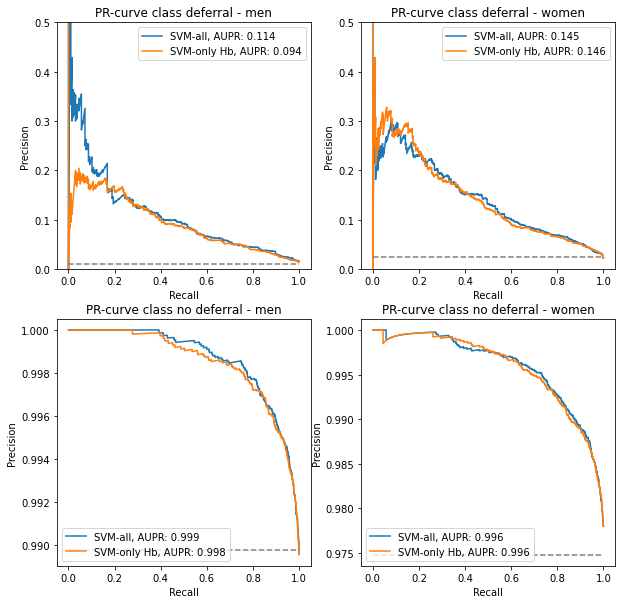

In [83]:
probas_onlyhb = load_probas(path='../results/probas_onlyhb/proba_')
probas['vars'] = 'all'
probas_onlyhb['vars'] = 'only Hb'

probas_all = pd.concat([probas, probas_onlyhb])
probas_5 = probas_all.loc[probas_all.nback == 5, ]


fig, ax = plt.subplots(2, 2, figsize=(10,10))

for x, sex in enumerate(['men', 'women']):
    df = probas_5.loc[probas_5['sex'] == sex, ]

    for key, group in df.groupby('vars'):
        precision_0, recall_0, thresholds_0 = precision_recall_curve(group.Hb_deferral, group.prob_low, pos_label=0)
        precision_1, recall_1, thresholds_1 = precision_recall_curve(group.Hb_deferral, group.prob_ok, pos_label=1)

        aupr_0 = round(average_precision_score(group.Hb_deferral, group.prob_low, pos_label=0), 3)
        aupr_1 = round(average_precision_score(group.Hb_deferral, group.prob_ok, pos_label=1), 3)

        ax[1,x].plot(recall_0, precision_0, label='SVM-'+str(key)+', AUPR: '+str(aupr_0))
        ax[0,x].plot(recall_1, precision_1, label='SVM-'+str(key)+', AUPR: '+str(aupr_1))

    ax[0,x].set_title('PR-curve class deferral - ' + ['men', 'women'][x])
    ax[0,x].set_xlabel('Recall')
    ax[0,x].set_ylabel('Precision')
    ax[1,x].set_title('PR-curve class no deferral - ' + ['men', 'women'][x])
    ax[1,x].set_xlabel('Recall')
    ax[1,x].set_ylabel('Precision')
    ax[0,x].legend(loc='upper right')
    ax[1,x].legend(loc='lower left')
    ax[0,x].set_ylim(0,0.5)

#horizontal lines for baseline
ax[0,0].hlines(y=def_m, xmin=0, xmax=1, color='grey', ls='--')
ax[1,0].hlines(y=1-def_m, xmin=0, xmax=1, color='grey', ls='--')
ax[0,1].hlines(y=def_f, xmin=0, xmax=1, color='grey', ls='--')
ax[1,1].hlines(y=1-def_f, xmin=0, xmax=1, color='grey', ls='--')

plt.savefig('../results/plots_performance/compare_PR_curve.png')

plt.show()